# 数据读入模块

In [274]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [275]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


## 处理NAN

In [276]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [277]:
df_train = delnan(train_data)
df_test = delnan(test_data)


In [278]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """


' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

## 转化为one-hot编码

In [279]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14"]


In [280]:
def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)


In [281]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]

x_col = basic_col+loan_col+overdue_col+query_col
# x_col为模型读入的自变量列名称


In [282]:
for i in x_col:
    if i not in df_test.columns:
        df_test[i] = 0


In [283]:
# df_train.drop(columns=drop_col)


# 训练模型

## 划分测试集训练集

In [284]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [285]:
N = 200
num_round = 300

max_depth = [3, 4, 5,7,15]
eta = [0.1,0.08,0.12]
colsample_bytree = [0.75, 0.7, 0.65]
scale_pos_weight = [1, 3, 6, 10, 30]
test_size=[0.1,0.2,0.3,0.5]


In [286]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
test_labels = []
loss_seq = []
max_auc_loss = 0

for i in range(N):

    X = df_train[x_col]
    Y = df_train["label"]

    #seed = 666
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=random.choice(test_size))
    # seed+=1

    x_perd = xgb.DMatrix(df_test[x_col])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    loss = float(bst.eval(dtest).split(":")[1])
    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    loss_seq.append(loss)

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
        best_param = param

    print(i+1, ":", loss, sep="")
    print(param)
    print("-------------------------")
    pred_labels.append([j for j in pred_label])
    test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(loss_seq), sep="")


1:0.7378159562621924
{'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.65, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'eval_metric': 'auc', 'seed': 666, 'tree_method': 'gpu_hist', 'gpu_id': 0}
-------------------------
2:0.675333741359447
{'max_depth': 5, 'eta': 0.08, 'colsample_bytree': 0.65, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'eval_metric': 'auc', 'seed': 666, 'tree_method': 'gpu_hist', 'gpu_id': 0}
-------------------------
3:0.7105155465293673
{'max_depth': 7, 'eta': 0.12, 'colsample_bytree': 0.75, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'eval_metric': 'auc', 'seed': 666, 'tree_method': 'gpu_hist', 'gpu_id': 0}
-------------------------
4:0.6854561338265421
{'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'scale_pos_weight': 10, 'eval_metric': 'auc', 'seed': 666, 'tree_method': 'gpu_hist', 'gpu_id': 0}
-------------------------
5:0.7263153727384298
{'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0

In [287]:
print(best_param)


{'max_depth': 3, 'eta': 0.12, 'colsample_bytree': 0.75, 'objective': 'binary:logistic', 'scale_pos_weight': 30, 'eval_metric': 'auc', 'seed': 666, 'tree_method': 'gpu_hist', 'gpu_id': 0}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

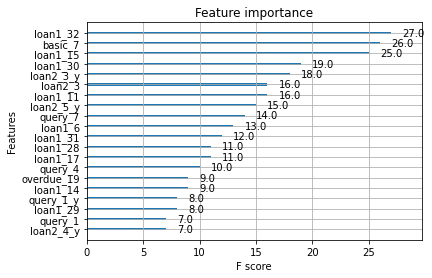

In [288]:
xgb.plot_importance(best_bst, max_num_features=20)


# 输出模块

In [290]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in loss_seq])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(y_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 40

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [loss_seq[i] for i in res_num], sep="")
# print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前40个auc为[0.8127157652474108, 0.7875663536137198, 0.7838233422425862, 0.7632774213165653, 0.7593022343299812, 0.7583237657864523, 0.7563308091737599, 0.7541650739041794, 0.7540478312537136, 0.7533123702527781, 0.7525652508299341, 0.7506669557593869, 0.7463409961685824, 0.7462203698879917, 0.7456195344650206, 0.7435235934929273, 0.7427975462620993, 0.7423124621659551, 0.7409340044198249, 0.74059706527239, 0.7402702852810069, 0.7396893186586959, 0.738046806360881, 0.7378159562621924, 0.7367224066520205, 0.7359563670625289, 0.7352234993614304, 0.7350161656406655, 0.7349981534042017, 0.7348667801575676, 0.7347777115218975, 0.7338178778708949, 0.7330776195251122, 0.7322240555258612, 0.731873019493479, 0.7317975101509931, 0.7307912339376871, 0.7296957599334891, 0.7291646665386585, 0.7290325322453837]


# 一些tips

* 提升n有一定提升(如何确定n？)

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？